# Sales-Prices Forecasting

---

GitHub Repository: [Repo](https://github.com/gsusAguirreArz/TimeSeriesForecasting)

In [1]:
{
    "tags": [
        "remove_input",
    ]
}

# Imports
import numpy as np
import matplotlib.pyplot as plt
from modules.data_utils.handler import *
from modules.data_utils.plots import *
from modules.data_utils.wrangler import *
from modules.data_utils.stats import *
from modules.training_utils.acc_metrics import *
%matplotlib inline

## Dataset

The dataset contains 3 months of daily sales volumes of 2399 products in 6 stores (not identically distributed along the stores, therefore we have 4933 time seriesfrom 01-08-2021 to 31-10-2021). The dataset has the following features:

| Feature Name | Description |
|--------------|-------------|
| id_stores | Store ID |
| id_products | Product ID |
| sales | Daily sales |
| prices | Daily prices |
| py_sales | Daily sales from last year |
| py_prices | Daily prices from last year |

The dataset contains 4 disctinct time series, 2 from one year and 2 from one year before, so I find interesting the dataset to try to predict sales and prices conditioned to prior information. But for one first approach we can try to forecast sales and prices.

In [2]:
{
    "tags": [
        "hide-input",
    ]
}

DATA_DIR = "./data"

TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"

TRAIN_PATH = get_path(DATA_DIR, TRAIN_FILE)
TEST_PATH = get_path(DATA_DIR, TEST_FILE)

train_df = load_train_data(TRAIN_PATH)
test_df = load_test_data(TEST_PATH)

In [3]:
train_df.index = pd.to_datetime(train_df.index)
train_df.head(4)

,id_stores,id_products,sales,prices,py_sales,py_prices
dates,,,,,,
2021-08-01,3,0,7.0,17.168571,5.0,21.063200
2021-08-02,3,0,6.0,17.141667,3.0,21.388667
2021-08-03,3,0,5.0,17.136000,5.0,21.376199
2021-08-04,3,0,4.0,16.995000,3.0,21.360367


### Total sales per store

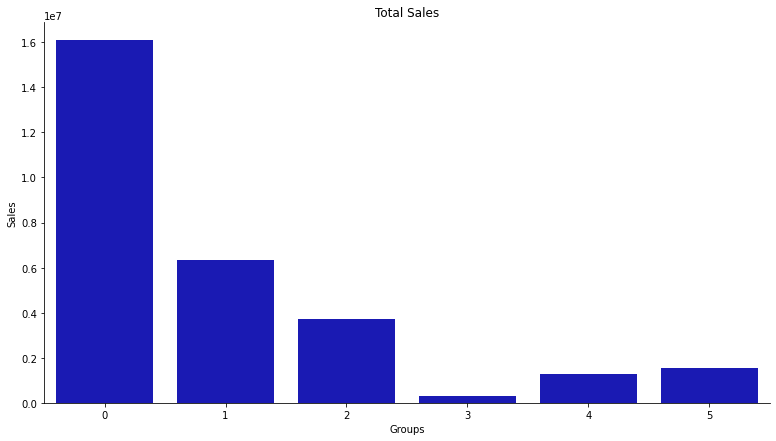

In [4]:
stores_sales_fig = sales_per_group_hist( col_name="id_stores", y="sales", data=train_df )

### Correlation plot

Key observations: 
- only features to have a linear relation are sales with py_sales and py_prices with prices
- this is expected since we can asume the increase or decrease in sales or prices

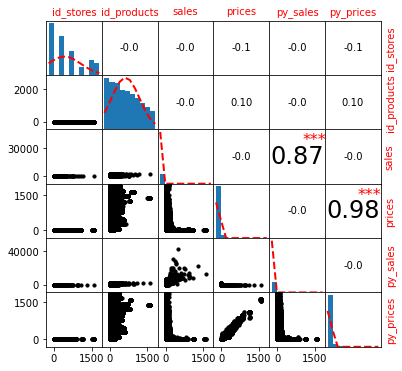

In [5]:
fig = correlation_plot( data=train_df.to_numpy(), col_names=train_df.columns.values.tolist(), fontSize=10 )

### Best selling product

The id for the best selling poduct is (1031) with 1400055 sales.

In [6]:
prods_sales = train_df.groupby("id_products").aggregate( {"sales": np.sum} )
best_selling_prod = prods_sales[prods_sales["sales"] == prods_sales['sales'].max()]
best_selling_prod

,sales
id_products,
1031,1.400055e+06


## Analysis

Visualizations of interesting insights.

### Seasonality patterns

Next we have the sales aggregation data for each year and the seasonality patterns for the sales features

/home/gsus/Documents/Python/projects/salesForecast/modules/data_utils/wrangler.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Week"] = df["dates"].dt.week
/home/gsus/Documents/Python/projects/salesForecast/modules/data_utils/wrangler.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Weekofyear"] = df["dates"].dt.weekofyear


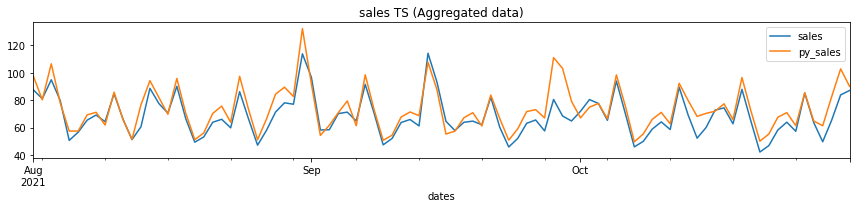

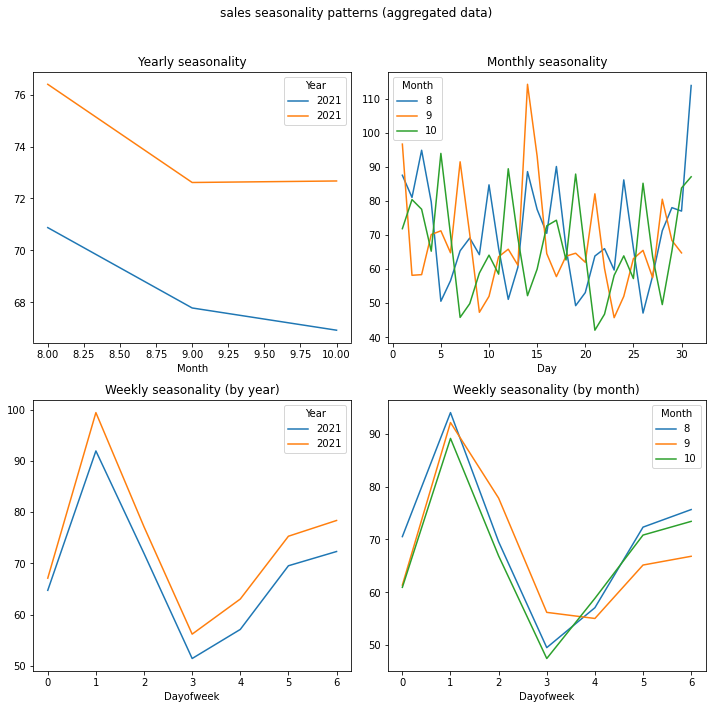

In [7]:
fig = plot_aggr_data( train_df, "sales")
fig = plot_seasonality_patterns( date_categorization( train_df ), "sales" )

### Annual trends

/home/gsus/Documents/Python/projects/salesForecast/modules/data_utils/wrangler.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Week"] = df["dates"].dt.week
/home/gsus/Documents/Python/projects/salesForecast/modules/data_utils/wrangler.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Weekofyear"] = df["dates"].dt.weekofyear


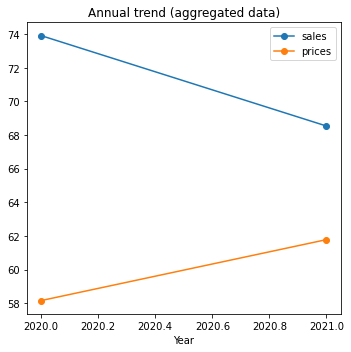

In [8]:
fig = plot_trend(date_categorization(merge_years(train_df)), ["sales", "prices"])

### Volatility accross products and stores (sales)

/home/gsus/Documents/Python/projects/salesForecast/modules/data_utils/wrangler.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Week"] = df["dates"].dt.week
/home/gsus/Documents/Python/projects/salesForecast/modules/data_utils/wrangler.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Weekofyear"] = df["dates"].dt.weekofyear


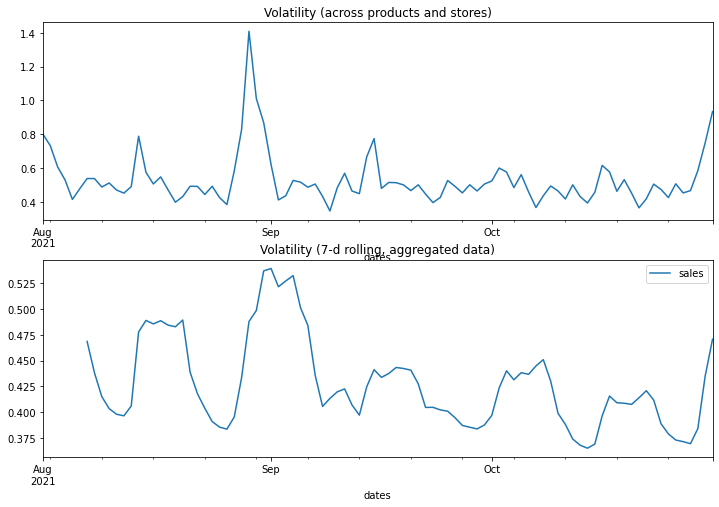

In [9]:
fig = plot_volatility(date_categorization(train_df), "sales")

## Single product visualizations

Next we will select the best selling product and plot important visualizations

In [10]:
store, product = 0, 1031
prod_df = train_df.query("id_stores == @store & id_products == @product")
# prod_df.head()

### Raw Time series

Plots of the time series of product 1031 foreach feature

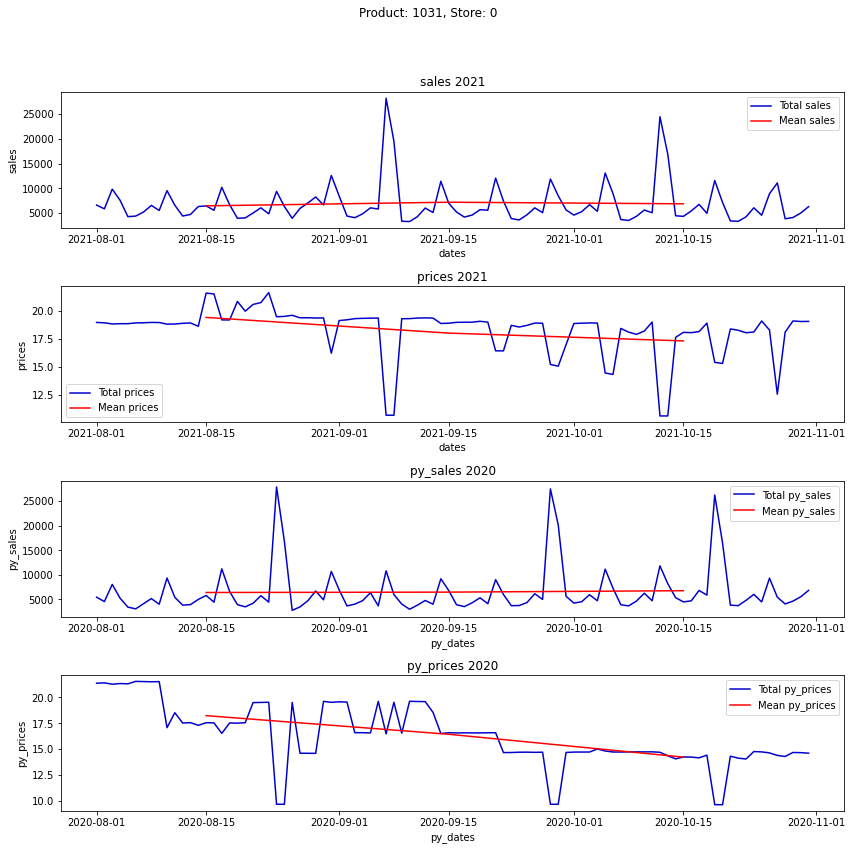

In [11]:
cols = ["sales", "prices", "py_sales", "py_prices"]
fig = show_plots( prod_df, cols, (store, product))

### Sationarity Test

Stationary test using Augmented Dickey-Fuller test

In [12]:
## Data is stationary?
info_df = product_time_series_stationarity(prod_df,cols)
selected_cols = info_df[info_df["is_stationary"] == False]["col_names"].to_numpy()
not_selected_cols = [col for col in cols if col not in selected_cols]
info_df.head()

,col_names,adf_stat,p_value,is_stationary
0,sales,-3.084718,0.027705,True
1,prices,-1.859174,0.351504,False
2,py_sales,-3.336366,0.013329,True
3,py_prices,-4.032312,0.001250,True


Transformation from non stationary data to stationary data

In [13]:
sttnry_prod_df = make_stationary_df(prod_df, selected_cols)
# print(prod_df.shape, sttnry_prod_df.shape)
new_cols = [col + "_diff" for col in selected_cols]
new_cols = [*not_selected_cols, *new_cols]
# sttnry_prod_df.head()

### Transformed Time series

Plost of stationary time series for each feature of product 1031

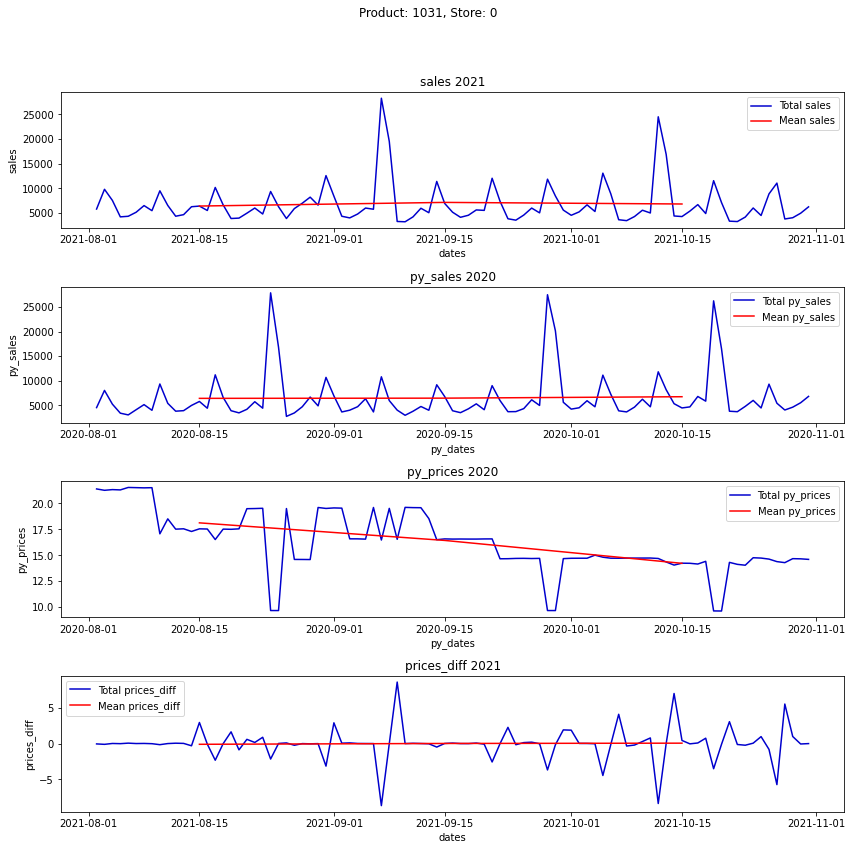

In [14]:
fig = show_plots( sttnry_prod_df, new_cols, (store, product))

Stationary test

In [15]:
## Data is stationary?
product_time_series_stationarity(sttnry_prod_df,new_cols)

,col_names,adf_stat,p_value,is_stationary
0,sales,-3.098705,0.026649,True
1,py_sales,-3.638440,0.005067,True
2,py_prices,-4.102502,0.000959,True
3,prices_diff,-5.372753,0.000004,True


### Causality test

Causality test using granger causality test 

In [16]:
## Data causality
# x_causes_y("sales_diff", "prices_diff", product_one_df)

causality_matrix( sttnry_prod_df, new_cols).head()

,names,sales,py_sales,py_prices,prices_diff
0,sales,NULL,No corr,No corr,sales causes prices_diff
1,py_sales,No corr,NULL,No corr,No corr
2,py_prices,No corr,No corr,NULL,No corr
3,prices_diff,No corr,No corr,No corr,NULL


### Autocorrealtion and Partial Autocorrealtion plots

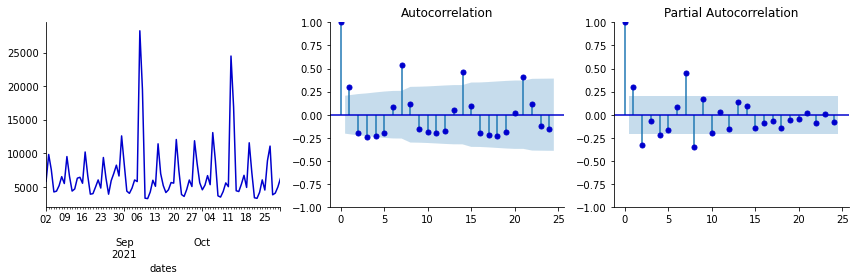

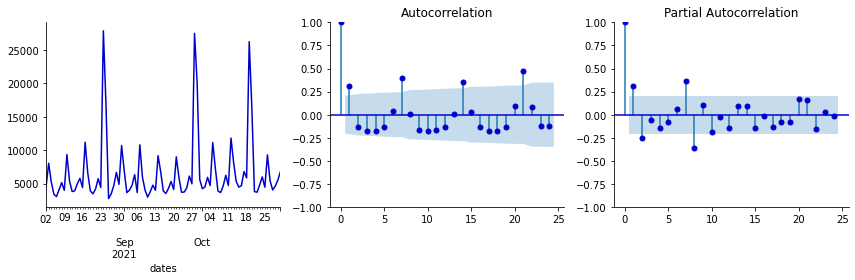

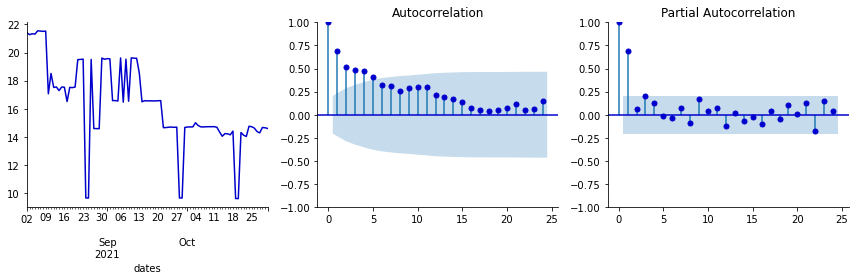

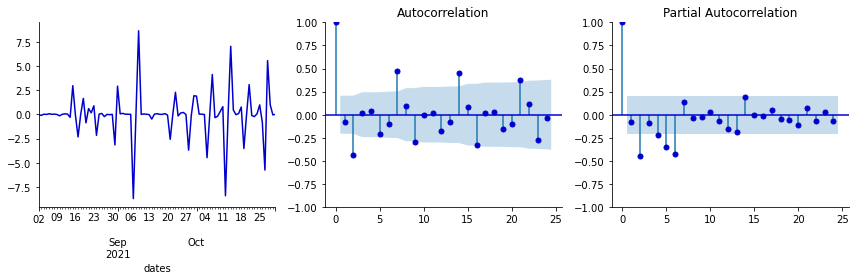

In [17]:
for col in new_cols:
    fig = ac_pac_plot(sttnry_prod_df, col, lags=24);

## Learning

For the task of forecasting time series we can use one of the following models:

1. Linear Regressor
2. Random Forest Regressor
3. Long Short Term Memory Neural Net
4. Vector AutoRegression
5. Prophet

---

### Model selection

I decided to use VAR, so in order to implment it we have to set up the following variables:

- explanation



In [18]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

data = prod_df[["sales","prices"]].copy()
# data.head()

train_data = data[:-15]
test_data = data[-15:]


In [19]:
# check lags
model = VAR(train_data.diff()[1:])
sorted_order = model.select_order(maxlags=10)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        17.52       17.58   4.054e+07       17.54
1        17.14       17.34   2.781e+07       17.22
2        17.07       17.40   2.580e+07       17.20
3        16.84       17.31   2.069e+07       17.03
4        16.78       17.38   1.950e+07       17.02
5        16.66       17.39   1.724e+07       16.94
6        16.33      17.19*   1.251e+07       16.67
7        16.32       17.32   1.244e+07       16.71
8       16.14*       17.27  1.050e+07*      16.59*
9        16.25       17.51   1.178e+07       16.75
10       16.31       17.70   1.267e+07       16.86
--------------------------------------------------


/home/gsus/miniconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Model Life Cycle

![Model LifeCycle](LifeCycle.jpg)

In [20]:
# fit model
var_model = VARMAX(train_data, order=(8,0), enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

/home/gsus/miniconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                            Statespace Model Results                           
Dep. Variable:     ['sales', 'prices']   No. Observations:                   77
Model:                          VAR(8)   Log Likelihood                -805.733
                           + intercept   AIC                           1685.466
Date:                 Wed, 08 Jun 2022   BIC                           1772.187
Time:                         20:52:33   HQIC                          1720.154
Sample:                     08-01-2021                                         
                          - 10-16-2021                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             1.29, 0.01   Jarque-Bera (JB):       1053.81, 51.16
Prob(Q):                        0.26, 0.92   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         4.57, 0.70   Skew:                       3.51, 1.00
Prob(H) (two-sided):        

/home/gsus/miniconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
n_forecast = 15
predict = fitted_model.get_prediction(start=len(train_data),end=len(train_data) + n_forecast-1)#start="1989-07-01",end='1999-01-01')
predictions=predict.predicted_mean

predictions.columns=['sales_pred','prices_pred' ]

test_vs_pred = pd.concat([test_data,predictions],axis=1)


In [22]:
test_vs_pred.head()

,sales,prices,sales_pred,prices_pred
2021-10-17,6718.200043,18.162643,6189.858975,18.640187
2021-10-18,4915.949963,18.926057,4476.979102,19.032447
2021-10-19,11560.663864,15.403130,16182.773711,15.322733
2021-10-20,7130.040031,15.316882,12108.762809,14.679983
2021-10-21,3374.470020,18.403284,2910.604080,18.594770


### Predictions vs Actual Values

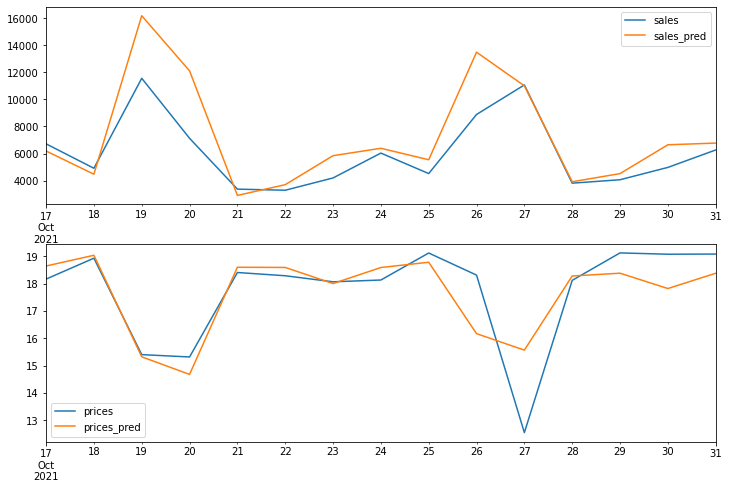

In [23]:
fig, axs = plt.subplots( 2, figsize=(12,8) )
_ = test_vs_pred[["sales", "sales_pred"]].plot(ax=axs[0])
_ = test_vs_pred[["prices", "prices_pred"]].plot(ax=axs[1])

### Accuracy metrics

We used the following metrics:

- RMSE
- MAE
- SMAPE
- R2 SCORE

In [24]:
print_acc_metrics( test_pred_df=test_vs_pred, feature="sales" )
print()
print_acc_metrics( test_pred_df=test_vs_pred, feature="prices" )

sales accuracy
Mean value: 6055.776587295532. RMSE: 2240.8793387788087
MAE: 1457.7198942217753
R2 Sore: 0.6596893860552061
SMAPE:  18.622754931382882

prices accuracy
Mean value: 17.73660814513849. RMSE: 1.077137464417342
MAE: 0.7108973188306884
R2 Sore: 0.40357320115409046
SMAPE:  4.29661993931621


### Frameworks and libraries

Data related libraries
- pandas
- numpy
- pysparl
- seaborn
- matplotlib

Machine learning libraries
- scikitlearn
- statsmodels
- tensorflow
- pytorch
- prophet

Deploymeny libraries
- streamlit

#### Time estimation

For the training and deployment of a model or multiple models that could predict forecast of each feature, I estimate 1 week of work until a first version is produced.

## Relationa schema

![EER](RegistersEERSchema.png)